In [1]:
# Knowledge Distillation Walkthrough in Google Colab
# In this notebook, we demonstrate knowledge distillation, where a smaller student model learns from a larger, trained teacher model using the CIFAR-10 dataset.

In [51]:
## Setup

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [15]:
# Load CIFAR-10 Dataset
# CIFAR-10 is a dataset of 60,000 32x32 color images in 10 classes, with 50,000 training and 10,000 test images.

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download and load the training and test datasets
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

100%|██████████| 170M/170M [00:13<00:00, 13.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [37]:
# Define the Teacher Model
# The teacher model is a larger CNN with two convolutional layers and two fully connected layers.
class TeacherModel(nn.Module):
    def __init__(self):
        super(TeacherModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling with 2x2 window
        self.fc1 = nn.Linear(128 * 16 * 16, 256)  # Fully connected layer
        self.fc2 = nn.Linear(256, 10) # Output layer for 10 classes

    def forward(self, x):
        x = F.relu(self.conv1(x))       # First convolutional layer with ReLU activation. Output: [batch_size, 64, 32, 32]
        x = self.pool(F.relu(self.conv2(x)))  # Second convolutional layer with pooling. Output: [batch_size, 128, 16, 16]
        x = x.view(-1, 128 * 16 * 16)   # Flatten the tensor to [batch_size, 128 * 16 * 16]
        x = F.relu(self.fc1(x)) # First fully connected layer with ReLU activation
        x = self.fc2(x) # Output layer
        return x

# Instantiate the teacher model and move it to the GPU
teacher_model = TeacherModel().to(device)

In [38]:
# Train the Teacher Model
# Function to train the teacher model using cross-entropy loss
def train_teacher(model, train_loader, epochs=5):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

In [39]:
# Train the teacher model
# Using early stopping by training the teacher for fewer epochs (5 epochs, compared to 10 epochs in students)
print("Training Teacher Model")
train_teacher(teacher_model, train_loader)

Training Teacher Model
Epoch 1/5, Loss: 1.3681
Epoch 2/5, Loss: 0.8232
Epoch 3/5, Loss: 0.9598
Epoch 4/5, Loss: 0.4891
Epoch 5/5, Loss: 0.3068


In [40]:
# Define the Student Model
# The student model is a smaller CNN with fewer filters and one fully connected layer.
class StudentModel(nn.Module):
    def __init__(self):
        super(StudentModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # New layer
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # Updated input size
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))  # Added layer
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the student models and move them to the GPU
student_model = StudentModel().to(device)
student_model_distilled = StudentModel().to(device)

In [45]:
# Knowledge Distillation Training
# Function to compute the distillation loss, combining soft and hard targets
def distillation_loss(student_logits, teacher_logits, target, alpha=0.5, temperature=4.0):
    # The temperature parameter controls the softness of the probability distribution.
    # Higher temperatures produce softer distributions, making it easier for the student
    # to learn from the teacher's outputs by focusing on the relative probabilities.

    # Compute the KL divergence between the softened student and teacher logits.
    # 1. The student logits are divided by the temperature and passed through a log-softmax function.
    # 2. The teacher logits are divided by the temperature and passed through a softmax function.
    # 3. The KL divergence measures how different the student distribution is from the teacher distribution.
    soft_loss = F.kl_div(
        F.log_softmax(student_logits / temperature, dim=1), # Log-softmax of student logits
        F.softmax(teacher_logits / temperature, dim=1), # Softmax of teacher logits
        reduction="batchmean" # Average over the batch
    ) * (temperature ** 2) # Scale the loss by temperature squared

    # The hard loss is the standard cross-entropy loss between the student logits and the true labels.
    hard_loss = F.cross_entropy(student_logits, target)

    # The total loss is a weighted sum of the hard loss and the soft loss.
    return alpha * hard_loss + (1 - alpha) * soft_loss

# Function to train the student model with or without distillation
def train_student(student_model, train_loader, distillation=False, teacher_model=None, epochs=10):
    optimizer = optim.Adam(student_model.parameters(), lr=0.0001)

    if distillation and teacher_model is None:
        raise ValueError("Teacher model is required for distillation.")
    if distillation and teacher_model is not None:
      teacher_model.eval()

    student_model.train()

    for epoch in range(epochs):
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()

            student_logits = student_model(data)

            if distillation and teacher_model is not None:
              with torch.no_grad():
                  teacher_logits = teacher_model(data)
              loss = distillation_loss(student_logits, teacher_logits, target)
            else:
              loss = F.cross_entropy(student_logits, target)


            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

In [42]:
# Fine-tune the student model without distillation
print("Student fine-tuning")
train_student(student_model, train_loader)

Student fine-tuning
Epoch 1/10, Loss: 1.5036
Epoch 2/10, Loss: 1.3451
Epoch 3/10, Loss: 1.5492
Epoch 4/10, Loss: 0.9970
Epoch 5/10, Loss: 1.1176
Epoch 6/10, Loss: 0.8985
Epoch 7/10, Loss: 0.8721
Epoch 8/10, Loss: 1.0488
Epoch 9/10, Loss: 1.2732
Epoch 10/10, Loss: 1.2594


In [46]:
# Train the student model with distillation
print("Student distillation from teacher")
train_student(student_model_distilled, train_loader, distillation=True, teacher_model=teacher_model)

Student distillation from teacher
Epoch 1/10, Loss: 2.6009
Epoch 2/10, Loss: 2.3941
Epoch 3/10, Loss: 1.9015
Epoch 4/10, Loss: 1.4738
Epoch 5/10, Loss: 1.9618
Epoch 6/10, Loss: 1.2760
Epoch 7/10, Loss: 1.7254
Epoch 8/10, Loss: 1.9078
Epoch 9/10, Loss: 1.3940
Epoch 10/10, Loss: 1.8890


In [47]:
# Evaluation
# Function to evaluate the model on the test dataset
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    print(f"Accuracy: {correct / len(test_loader.dataset) * 100:.2f}%")

print("Teacher Model Performance:")
evaluate(teacher_model, test_loader)

print("Student Model Performance without distillation:")
evaluate(student_model, test_loader)

print("Student Model Performance with distillation:")
evaluate(student_model_distilled, test_loader)

Teacher Model Performance:
Accuracy: 68.64%
Student Model Performance without distillation:
Accuracy: 64.83%
Student Model Performance with distillation:
Accuracy: 66.92%


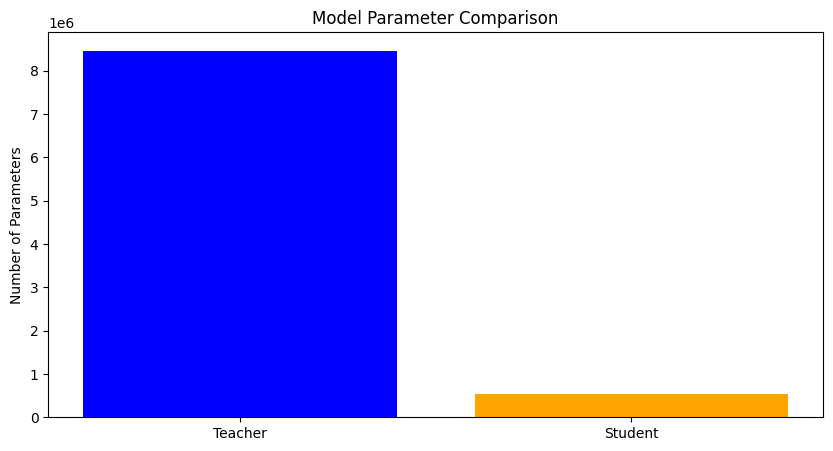

In [48]:
# Visualization
# Compare the number of parameters between teacher and student models
plt.figure(figsize=(10, 5))
x = ["Teacher", "Student"]
y = [
    sum(p.numel() for p in teacher_model.parameters()),
    sum(p.numel() for p in student_model.parameters())
]
plt.bar(x, y, color=['blue', 'orange'])
plt.title("Model Parameter Comparison")
plt.ylabel("Number of Parameters")
plt.show()

In [52]:
# Key Learnings while learning:
# 1. Fine-tuning the student for 10 epochs after using an early-stopped teacher (5 epochs) can yield better results.
# 2. Increasing the temperature to 4 and using a balanced alpha (0.5) helps improve the distillation process.